In [18]:
# Force keras to use the CPU becuase it's actually faster for this size network
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBE_DEVICES"] = ""

import numpy as np
import pandas as pd

from numpy import cos, sin, pi
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline
import matplotlib.animation as animation

from IPython.display import HTML

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import max_norm



# TODO should move all this to a module (probably merge with the old cartpole module we were using)..
# or refactor out that to be more like the walker code, either way everything is inconsitent right now 
# and you should fix that

# Define constants (geometry and mass properties):
m1=1; m2=1; L1=1; L2=1; Lc1=.5; Lc2=.5; I1=.2; I2=1; g=9.8;




rad = np.pi / 180
u_hist = []


#animation generation
def animate_pend(y):
    
    th1 = y[:,0]
    th2 = y[:,1]
    
    x1 = L1 * cos(th1)
    y1 = L1 * sin(th2)
    
    x2 = L2 * cos(th1 + th2) + x1
    y2 = L2 * sin(th1 + th2) + y1

    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, aspect='equal', \
                     xlim=(-3, 3), ylim=(-3, 3))
    ax.grid()

    line1, = ax.plot([], [], 'o-', lw=2)
    line2, =  ax.plot([], [], 'o-', lw=2)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


    def init():
        line1.set_data([], [])
        line2.set_data([], [])
        time_text.set_text('')
        return line1, line2, time_text


    def animate(i):
     
        line1.set_data([0 ,x1[i]] , [0, y1[i]])
        line2.set_data([x1[i], x2[i]] , [y1[i], y2[i]])


        time_text.set_text(time_template % (i * dt))
        return line1,line2, time_text


    return animation.FuncAnimation(fig, animate, np.arange(1, len(y)), interval=40, blit=True, init_func=init)



# control input: u = F
# q is the state vector
# def control(q):
#     if (q[0] < 140 * rad) or (q[0] > 220 * rad):
#         # swing up
#         # energy error: Ee
#         Ee = 0.5 * m * L * L * q[2] ** 2 - m * g * L * (1 + cos(q[0]))
#         # energy control gain:
#         k = 0.23
#         # input acceleration: A (of cart)
#         A = k * Ee * cos(q[0]) * q[2]
#         # convert A to u (using EOM)
#         delta = m * sin(q[0]) ** 2 + M
#         u = A * delta - m * L * (q[2] ** 2) * sin(q[0]) - m * g * sin(q[2]) * cos(q[2])
#     else:
#         # balancing
#         # LQR: K values from MATLAB
#         k1 = 140.560
#         k2 = -3.162
#         k3 = 41.772
#         k4 = -8.314
#         u = -(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
        
#     return u


# state vector: q = transpose([theta, x, d(theta)/dt, dx/dt])
def derivs(q, t):
    #TODO should definitley move this outside of python, would be a nice excuse to learn how to write a C module that interfaces with python

    # control input
    u = control(q,t)

    
    # dynamic equations of motion for acrobot, for use by ode45
    # katiebyl 1/12/2010


    # Extract state variables from X:
    q1 = q[0]; q2 = q[1]; dq1 = q[2]; dq2 = q[3];

    # Need to define torque somehow...
    tau = 0
    TAU = np.array([0, tau])

    m11 = m1*Lc1**2 + m2*(L1**2 + Lc2**2 + 2*L1*Lc2*cos(q2)) + I1 + I2
    m22 = m2*Lc2**2 + I2
    m12 = m2*(Lc2**2 + L1*Lc2*cos(q2)) + I2
    M = np.array([[m11, m12], [m12, m22]])

    h1 = -m2*L1*Lc2*sin(q2)*dq2**2 - 2*m2*L1*Lc2*sin(q2)*dq2*dq1
    h2 = m2*L1*Lc2*sin(q2)*dq1**2
    H = np.array([h1, h2])

    phi1 = (m1*Lc1+m2*L1)*g*cos(q1) + m2*Lc2*g*cos(q1+q2)
    phi2 = m2*Lc2*g*cos(q1+q2)
    PHI = np.array([phi1, phi2])

    # M*d2Q + H + PHI = TAU
    # d2Q = inv(M)*(TAU - H - PHI);

    #TAU;
    import ipdb
    iphd.set_trace()
    #-H;

    #-PHI;

    # d2Q = (M**-1)*(TAU - H - PHI);
    d2Q = np.linalg.solve(M,TAU-H-PHI)
    #dX = [dq1, dq2, d2Q]
    
    
    #dq1 = (l1* lG2**2 * M2**2 * cos(q[0] - q[1])*( g*cos(q[1]) - q[2]**2*l1*sin(q[0] - q[1])) \
    #       - (J2 + lG2**2*M2)*(-u + g*lG1*M1 + l1*M2)*cos(q[0] + q[3]**2 * l1*lG2*M2*sin(q[0] - q[1]))) \
    #        / (-(J1 + l1^2*M2)*(J2 + lG2**2 * M2) + l1**2 * lG2 **2 * M2**2 * cos(q[0] - q[1])**2)
               
    
    #dq2 = (2 * lG2 * M2 * ((J1 + l1**2 * M2) * (-g * cos(q[1]) + q[2]**2 * l1 * sin(q[0] - q[1]) + \
    #       l1 * cos(q[0] - q[1]) * (-u + g * (lG1 * M1 + l1 * M2) * cos(q[1]) + \
    #        q[3]**2 * l1 * lG2 * M2 * sin(q[0] - q[1])))/(-2 * J1 * (J2 + lG2**2 * M2) - \
    #         l1**2 * M2 * (2 * J2 + lG2**2 * M2) + l1**2 * lG2**2 * M2**2 * cos(2 * (q[0] - q[1]))))) 

    return np.array([q[2], q[3], d2Q[0], d2Q[1]])

In [19]:
def control(q,t=0):
    return 0

# time step
dt = 0.1
t = np.arange(0.0, 20, dt)

rad = np.pi / 180


num_trials = 1
num_states = 4
num_t = len(t)
y = np.zeros((num_t, num_states, num_trials))

th1 = 1.0
th2 = 0.0
dth1 = 0.0
dth2 = 0.0

# initial state
state = np.array([th1, th2, dth1, dth2])

# integrate the ODE using scipy.integrate.
u_hist = []
y = integrate.odeint(derivs, state, t)
plt.plot(y)


NameError: name 'iphd' is not defined

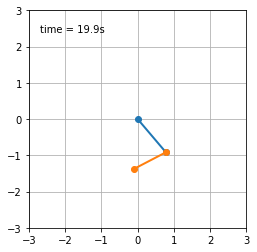

In [17]:
# time step
dt = 0.1
t = np.arange(0.0, 20, dt)

rad = np.pi / 180


num_trials = 1
num_states = 4
num_t = len(t)
y = np.zeros((num_t, num_states, num_trials))


for i in range(num_trials):
    # initial conditions
    th1 = 0.0
    th2 = 0.0
    dth1 = 0.1#2*(i/num_trials) - 1  # an initial velocity, triggers the swing up control
    dth2 = 0.0

    # initial state
    state = np.array([th1, th2, dth1, dth2])

    # integrate the ODE using scipy.integrate.
    u_hist = []
    y[:, :, i] = integrate.odeint(derivs, state, t)


u = np.zeros((num_t, num_trials))
for i in range(num_trials):
    for t in range(num_t):
        u[t,i] = control(y[t,:,i]) 

        
ani = animate_pend(y[:,:,0])
HTML(ani.to_jshtml())

In [ ]:
# Create our LSTM network

look_back = 1

with tf.variable_scope('pi/pol/'):
    model = Sequential()
    model.add(LSTM(12, input_shape=(4,look_back)))
    #model.add(LSTM(4, input_shape =(12,look_back)))
    model.add(Dense(1))

    #model.add(Dense(2))
    

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(y, u, epochs=500, verbose=0)
%matplotlib inline
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
# This is a closure that returns our NN controller
def make_controller(model):
    def nn_controller(q):
        if (q[0] < 140 * rad) or (q[0] > 220 * rad):
            return model.predict(q.reshape((1,4,1)))
        else:
            # balancing
            # LQR: K values from MATLAB
            k1 = 140.560
            k2 = -3.162
            k3 = 41.772
            k4 = -8.314
            u = -(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
            return u
        
    return nn_controller

In [ ]:
control = make_controller(model)

# initial conditions
theta = 0
x = 0
th_dot = .01 # an initial velocity, triggers the swing up control
xdot = 0.0
t = np.arange(0.0, 20, dt)


# initial state
state = np.array([theta, x, th_dot, xdot])

# integrate the ODE using scipy.integrate.
y_test = integrate.odeint(derivs, state, t)

#ani = animate_pend(y_test)
#HTML(ani.to_html5_video())

In [ ]:
def run_swingup():
    control = make_controller(model)
    
    # initial conditions
    theta = 0
    x = 0
    th_dot = .01 # an initial velocity, triggers the swing up control
    xdot = 0.0
    t = np.arange(0.0, 20, dt)


    # initial state
    state = np.array([theta, x, th_dot, xdot])

    # integrate the ODE using scipy.integrate.
    y_test = integrate.odeint(derivs, state, t)

    #ani = animate_pend(y_test)
    #HTML(ani.to_html5_video())

In [ ]:
control = make_controller(model)

# initial conditions
theta = 0
x = 0
th_dot = .01 # an initial velocity, triggers the swing up control
xdot = 0.0
t_index = np.arange(0.0, 2, dt)


# initial state
state = np.array([theta, x, th_dot, xdot])

# integrate the ODE using scipy.integrate.
# Fill in our u after the fact..
y_test = integrate.odeint(derivs, state, t_index)
u_test = np.zeros((y.shape[0],1))
for t in range(num_t):
        u_test[t] = control(y[t]) 

        
data = np.concatenate((y_test, u_test),axis=1)
names = ['theta','x','thetadot','xdot','u']
yf = pd.DataFrame(data = data, index = t_index, columns = names)


ani = animate_pend(y_test)
HTML(ani.to_html5_video())

In [ ]:
plt.plot(yf['state','theta'])
old_theta = yf['state','theta']


In [ ]:
new_theta = yf['theta']

In [ ]:
np.all(old_theta == new_theta)

In [ ]:
N_train = 1000
from numpy.random import choice
one_indexes = choice(a=N_train, size=int(N_train / 2), replace=False)
X_train[one_indexes, 0] = 1  # very long term memory.

In [ ]:
# messing with multiindexing 
# TODO probably move this to the misc folder, preferably as a more complete example than this one.

names = [
    ('state', 'theta'),
    ('state', 'x'),
    ('state', 'thetadot'),
    ('state', 'xdot'),
    ('control' ,'u')
]

yf = pd.DataFrame(data = data, index = t_index, columns=pd.MultiIndex.from_tuples(names))